### Libraries

In [1]:
# from az_common_funcs import *
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable

import seaborn as sns
sns.set_theme(style='darkgrid')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Importing Competition DataSets

In [3]:
df_main = pd.read_csv("../input/digit-recognizer/train.csv")
df_submission = pd.read_csv('../input/digit-recognizer/test.csv')

### Preprocessing and Data Exploration

In [4]:
# index_to_split_on = list(range(df_main.shape[0]))
# random.shuffle(a)

random.seed(30)
index_to_split_on = random.sample(range(df_main.shape[0]), k = int(0.9 * df_main.shape[0]))

In [5]:
df_train = df_main.iloc[index_to_split_on].reset_index(drop = True)
df_test = df_main.drop(index_to_split_on, axis = 0).reset_index(drop = True)

In [6]:
train = df_train.iloc[:,0].to_frame()

In [7]:
train['pixels'] = list(df_train.iloc[:,1:].values)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37800 entries, 0 to 37799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   37800 non-null  int64 
 1   pixels  37800 non-null  object
dtypes: int64(1), object(1)
memory usage: 590.8+ KB


In [9]:
# rows = iter(train[train.label == 0].index)
rows = iter(train.index)

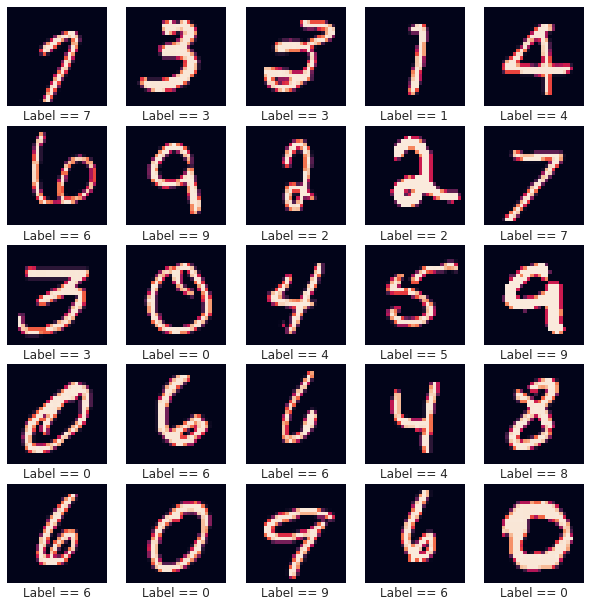

In [10]:
# row = 45
# plt.title(f"Label == {train.loc[row,'label']}")
# plt.imshow(train.loc[row,'pixels'].reshape(28,28,1))

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    row = next(rows)
    plt.title(f"Label == {train.loc[row,'label']}", y = -0.2)
    plt.imshow(train.loc[row,'pixels'].reshape(28,28,1))
    plt.axis('off')

    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
plt.show()

### Model 2 Training and Results
1. Model : CNN
2. Padding : True
3. Pooling : True
4. Layers : 8 Layers
5. Dropout : 0.1

In [11]:
class MyDataset():
    def __init__(self, df_input):
        
        x = df_input.iloc[:,1:].values
        y = df_input.iloc[:,0].values
        
        self.x_train = torch.tensor(x, dtype=torch.float32)
        self.y_train = torch.tensor(y, dtype=torch.int32)
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self,idx):
        return self.x_train[idx], self.y_train[idx]
    
    def __shape_of_xy__(self):
        print(f"size of x : {self.x_train.size()}")
        print(f"size of y : {self.y_train.size()}")

In [12]:
def compute_accuracy(Y, Y_pred):
    Y_pred = Y_pred.data.max(dim=1)[1]
    
    acc = (Y == Y_pred).float().mean() 
    
    # Explanation Example
    # (torch.tensor(np.array([1,2,3,4,5])) == torch.tensor(np.array([1,2,4,6,5]))).float().mean().item()
    
    return acc.item()

In [13]:
def compute_accuracy_no_calc(Y, Y_pred):
    
    acc = (Y == Y_pred).float().mean() 
    
    # Explanation Example
    # (torch.tensor(np.array([1,2,3,4,5])) == torch.tensor(np.array([1,2,4,6,5]))).float().mean().item()
    
    return acc.item()

In [14]:
class CNN_2(torch.nn.Module):
    
    def __init__(self, keep_prob):
        
        super(CNN_2, self).__init__()
        
        self.keep_prob = keep_prob
        # Layer 1
        # I : (?, 1, 28, 28)
        # O : (?, 32, 14,14)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_1 = torch.nn.Sequential(torch.nn.Conv2d(1, 32, kernel_size = 3, padding = 1, stride = 1),
                                               torch.nn.ReLU(),
                                               torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 2
        # I : (?, 32, 14, 14)
        # O : (?, 64, 7, 7)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_2 = torch.nn.Sequential(torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1, stride = 1),
                                               torch.nn.ReLU(),
                                               torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 3
        # I : (?, 64, 7, 7)
        # O : (?, 128, 7, 7)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_3 = torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1, stride = 1),
                                               torch.nn.ReLU(),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 4
        # I : (?, 128, 7, 7)
        # O : (?, 256, 2, 2)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_4 = torch.nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size = 3, padding = 1, stride = 2),
                                               torch.nn.ReLU(),
                                               torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 5
        # I : (?, 256, 2, 2)
        # O : (?, 1024)
        self.flatten_layer_1 = torch.nn.Sequential(torch.nn.Flatten())
        
        
        # Layer 6
        # I : (?, 1024)
        # O : (?, 512)
        self.fc_layer_1 = torch.nn.Sequential(torch.nn.Linear(1024, 512),
                                              torch.nn.ReLU(),
                                              torch.nn.Dropout(p = 1 - self.keep_prob)
                                             )

        # Layer 7
        # I : (?, 512)
        # O : (?, 250)
        self.fc_layer_2 = torch.nn.Sequential(torch.nn.Linear(512, 250),
                                              torch.nn.ReLU(),
                                              torch.nn.Dropout(p = 1 - self.keep_prob)
                                             )
        
        # Layer 8
        # I : (?, 512)
        # O : (?, 250)
        self.fc_layer_3 = torch.nn.Sequential(torch.nn.Linear(250, 10))
        
    
    def forward(self,x):
        a = self.cnn_layer_1(x)
        a = self.cnn_layer_2(a)
        a = self.cnn_layer_3(a)
        a = self.cnn_layer_4(a)
        a = self.flatten_layer_1(a)
        a = self.fc_layer_1(a)
        a = self.fc_layer_2(a)
        a = self.fc_layer_3(a)
        
        return a

In [15]:
model = CNN_2(0.9)
model.to(device)
model

CNN_2(
  (cnn_layer_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.09999999999999998, inplace=False)
  )
  (cnn_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.09999999999999998, inplace=False)
  )
  (cnn_layer_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.09999999999999998, inplace=False)
  )
  (cnn_layer_4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.09999999999999998, inplace=False)
  )
  (flatten_layer_1): Se

In [16]:
data_set = MyDataset(df_train)

In [17]:
batch_size = 64
data_loader = torch.utils.data.DataLoader(dataset = data_set,
                                          batch_size = batch_size,
                                          shuffle = True)

In [18]:
print("""********************* Model 2 Training ***************************""")
learning_rate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

epochs = 15 
train_acc = []
train_cost = []

for epoch in range(epochs):
    avg_cost = 0
    print(f"Epoch {epoch + 1} Starting")
    for batch_no, (batch_x, batch_y) in enumerate(data_loader, start = 1):
        if batch_x.size()[0] < batch_size : continue
        
        X_train = Variable(batch_x).reshape(batch_size, 1, 28, 28).to(device) # reshaping the input tensor 
        Y_train = Variable(batch_y)
        Y_train = Y_train.type(torch.LongTensor).to(device)
        
        optimizer.zero_grad() # zeroing the gradients
        
        hypothesis = model(X_train) # making a forward pass
        
        cost = criterion(hypothesis, Y_train) # caculating the cost
        
        cost.backward() # making a backward pass
        
        optimizer.step() # updating the parameters
        
        batch_accuracy = compute_accuracy(Y_train, hypothesis) # Calculating Batch Accuracy
        
        train_acc.append(batch_accuracy)
        train_cost.append(cost.item())
        
        if batch_no % 100 == 0 :
            print(f"Epoch {epoch + 1} :: Batch {batch_no} done :: Accuracy = {batch_accuracy : .2%}")
        
        avg_cost += cost.item() / batch_size
        
    print(f"Epoch {epoch + 1} Done with Avg Cost = {avg_cost}")


********************* Model 2 Training ***************************
Epoch 1 Starting
Epoch 1 :: Batch 100 done :: Accuracy =  96.88%
Epoch 1 :: Batch 200 done :: Accuracy =  95.31%
Epoch 1 :: Batch 300 done :: Accuracy =  100.00%
Epoch 1 :: Batch 400 done :: Accuracy =  96.88%
Epoch 1 :: Batch 500 done :: Accuracy =  98.44%
Epoch 1 Done with Avg Cost = 2.4080614301929018
Epoch 2 Starting
Epoch 2 :: Batch 100 done :: Accuracy =  100.00%
Epoch 2 :: Batch 200 done :: Accuracy =  98.44%
Epoch 2 :: Batch 300 done :: Accuracy =  98.44%
Epoch 2 :: Batch 400 done :: Accuracy =  98.44%
Epoch 2 :: Batch 500 done :: Accuracy =  100.00%
Epoch 2 Done with Avg Cost = 0.7138511756529624
Epoch 3 Starting
Epoch 3 :: Batch 100 done :: Accuracy =  98.44%
Epoch 3 :: Batch 200 done :: Accuracy =  100.00%
Epoch 3 :: Batch 300 done :: Accuracy =  96.88%
Epoch 3 :: Batch 400 done :: Accuracy =  96.88%
Epoch 3 :: Batch 500 done :: Accuracy =  98.44%
Epoch 3 Done with Avg Cost = 0.5804357640590752
Epoch 4 Starti

In [19]:
def prediction_function(self, batch_size, model):
    max_rows = self.shape[0]
    Y_pred = []
    
    iter_length = batch_size
    
    i_start = 0
    i_end = i_start + iter_length

    while i_start != i_end:
        res = model(torch.tensor(self.iloc[i_start:i_end].values, dtype = torch.float32).reshape(i_end-i_start, 1, 28, 28).to(device)) 
        res = res.data.max(dim=1)[1]

        # res_append
        Y_pred.extend(res)

        if i_end%(iter_length*50) == 0: print(f"{i_end} rows done!")

        # increment the indexes
        i_start = i_end
        i_end = i_start + iter_length
        if i_end > max_rows:
            i_end = max_rows
    print("All rows done!")
    
    return torch.tensor(Y_pred).to(device)

pd.DataFrame.prediction_function = prediction_function

In [20]:
Y_pred_train = df_train.iloc[:,1:].prediction_function(64, model)

3200 rows done!
6400 rows done!
9600 rows done!
12800 rows done!
16000 rows done!
19200 rows done!
22400 rows done!
25600 rows done!
28800 rows done!
32000 rows done!
35200 rows done!
All rows done!


In [21]:
# Y_pred_train = model_2(torch.tensor(df_train.iloc[:,1:].values, dtype = torch.float32).reshape(df_train.shape[0], 1, 28, 28)) 

In [22]:
# Y_pred_test = model_2(torch.tensor(df_test.iloc[:,1:].values, dtype = torch.float32).reshape(df_test.shape[0], 1, 28, 28).to(device)).data.max(dim=1)[1]

In [23]:
# Y_pred = Y_pred.data.max(dim=1)[1]

In [24]:
Y_pred_test = df_test.iloc[:,1:].prediction_function(64, model)

3200 rows done!
All rows done!


In [25]:
Y_train = torch.tensor(df_train.iloc[:,0].values, dtype = torch.int32).type(torch.LongTensor).to(device)

In [26]:
Y_test = torch.tensor(df_test.iloc[:,0].values, dtype = torch.int32).type(torch.LongTensor).to(device)

In [27]:
print(f"Accuracy for the train set is = {compute_accuracy_no_calc(Y_train, Y_pred_train) : .2%}")
print(f"Accuracy for the test set is = {compute_accuracy_no_calc(Y_test, Y_pred_test) : .2%}")
# Model1 - 99.46 % and 98.36 %, 1.1% difference
# Model2 - 99.28 % and 98.81 %, 0.47% difference

Accuracy for the train set is =  99.36%
Accuracy for the test set is =  98.55%


In [28]:
# file_path = f"models/"
# model_name = "CNN_2"

# # save
# torch.save(model_2.state_dict(), f'{file_path}/{model_name}.pt')

# # load
# # model_2 = CNN_2(0.9)
# # model_2.load_state_dict(torch.load(f'{file_path}/{model_name}.pt'))

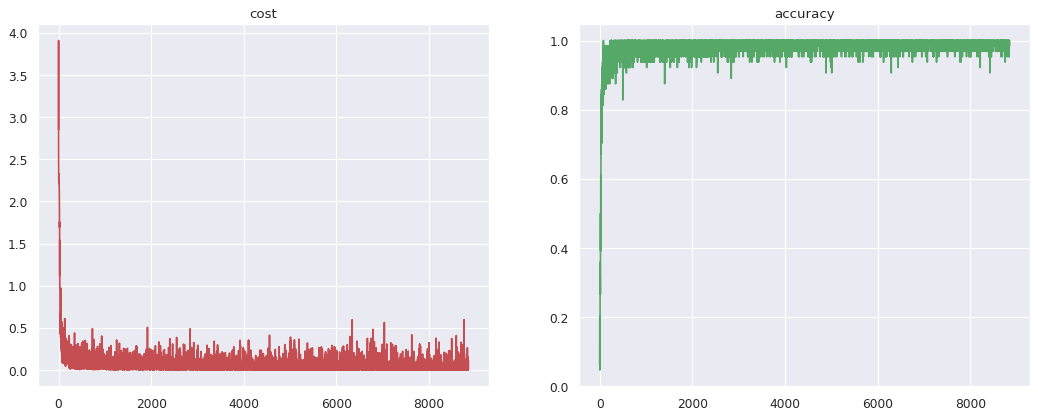

In [29]:
# plt.figure(figsize=(8, 6), dpi=80)
fig, axs = plt.subplots(ncols=2, figsize=(16, 6), dpi=80)
p1, = axs[0].plot(train_cost, color = 'r')
axs[0].set_title("cost")
p2, = axs[1].plot(train_acc, color = 'g')
axs[1].set_title("accuracy")
# plt.legend([p1,p2], ['cost', 'accuracy'], loc = 'upper right')
plt.show()

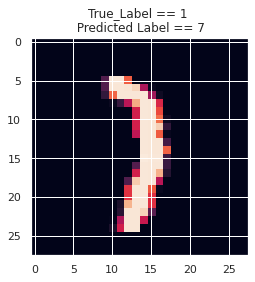

In [30]:
row = 1137
# plt.title(f"Label == {test.loc[row,'label']}")
X_test_sample = torch.tensor(df_test.iloc[row,1:].values, dtype = torch.float32).reshape(1,1,28,28).to(device)
test_label = model(X_test_sample).data.max(dim=1)[1].item()
plt.title(f"True_Label == {df_test.iloc[row,0]} \n Predicted Label == {test_label}")
plt.imshow(df_test.iloc[row,1:].values.reshape(28,28,1))

In [31]:
test = df_test.iloc[:,0].to_frame()
test['pixels'] = list(df_test.iloc[:,1:].values)

In [32]:
test['pred_label_model_2'] = df_test.iloc[:,1:].prediction_function(64, model).tolist()

3200 rows done!
All rows done!


In [33]:
rows = iter(test.query("(label != pred_label_model_2) and label == 2").index)
# rows = iter(test.index)
# print(list(rows), len(list(rows)))

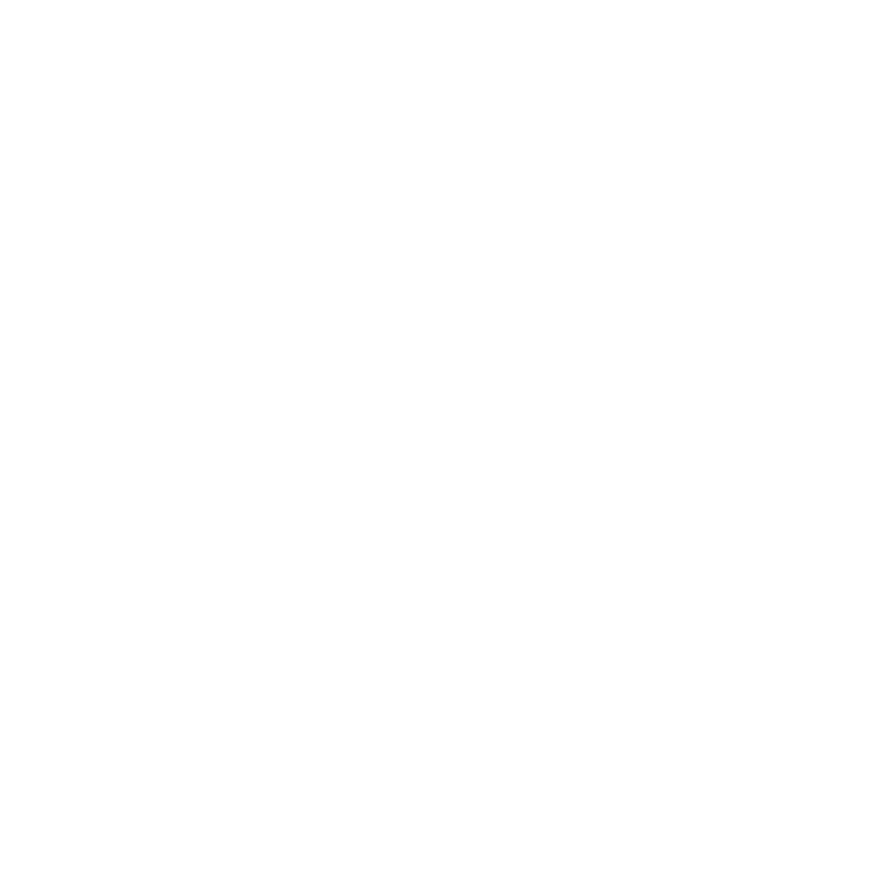

In [34]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(25):
    row = next(rows,"invalid")
    if row != 'invalid' :
#     X_test_sample = torch.tensor(test.loc[row, 'pixels'], dtype = torch.float32).reshape(1,1,28,28)
#     predicted_label_sample = model(X_test_sample).max(dim = 1)[1]

        plt.subplot(5,5,i+1) # the number of images in the grid is 5*5 (25)
        plt.title(f"Label == {test.loc[row,'label']} \n\
        Predicted_Label_M2 == {test.loc[row,'pred_label_model_2']}", y = -0.3)

        plt.imshow(test.loc[row,'pixels'].reshape(28,28,1))
    plt.axis('off')

    
plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=1.4, 
                    top=1.4, 
                    wspace=0.1, 
                    hspace=0.1)
plt.show()

### Conclusions and Submission

In [35]:
print(f"Total Parameters in Model          : {sum(p.numel() for p in model.parameters()) : ,}")
print(f"Total Trainable Parameters in Model 2 : {sum(p.numel() for p in model.parameters() if p.requires_grad) : ,}")

Total Parameters in Model          :  1,043,400
Total Trainable Parameters in Model 2 :  1,043,400


Before this architecture, I had tried one with no pooling layer, smaller batch-size and no padding. That architecture had more than 6 M trainable parameters. The architecture is as follows. You can try for yourselves.

```python
class CNN_2(torch.nn.Module):
    
    def __init__(self, keep_prob):
        
        super(CNN_2, self).__init__()
        
        self.keep_prob = keep_prob
        # Layer 1
        # I : (?, 1, 28, 28)
        # O : (?, 32, 14,14)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_1 = torch.nn.Sequential(torch.nn.Conv2d(1, 32, kernel_size = 3, padding = 1, stride = 1),
                                               torch.nn.ReLU(),
                                               torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 2
        # I : (?, 32, 14, 14)
        # O : (?, 64, 7, 7)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_2 = torch.nn.Sequential(torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1, stride = 1),
                                               torch.nn.ReLU(),
                                               torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 3
        # I : (?, 64, 7, 7)
        # O : (?, 128, 7, 7)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_3 = torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1, stride = 1),
                                               torch.nn.ReLU(),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 4
        # I : (?, 128, 7, 7)
        # O : (?, 256, 2, 2)
        # size(o) : (n + 2p - f)/s + 1
        self.cnn_layer_4 = torch.nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size = 3, padding = 1, stride = 2),
                                               torch.nn.ReLU(),
                                               torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                                               torch.nn.Dropout(p = 1 - self.keep_prob)
                                              )
        
        # Layer 5
        # I : (?, 256, 2, 2)
        # O : (?, 1024)
        self.flatten_layer_1 = torch.nn.Sequential(torch.nn.Flatten())
        
        
        # Layer 6
        # I : (?, 1024)
        # O : (?, 512)
        self.fc_layer_1 = torch.nn.Sequential(torch.nn.Linear(1024, 512),
                                              torch.nn.ReLU(),
                                              torch.nn.Dropout(p = 1 - self.keep_prob)
                                             )

        # Layer 7
        # I : (?, 512)
        # O : (?, 250)
        self.fc_layer_2 = torch.nn.Sequential(torch.nn.Linear(512, 250),
                                              torch.nn.ReLU(),
                                              torch.nn.Dropout(p = 1 - self.keep_prob)
                                             )
        
        # Layer 8
        # I : (?, 512)
        # O : (?, 250)
        self.fc_layer_3 = torch.nn.Sequential(torch.nn.Linear(250, 10))
        
    
    def forward(self,x):
        a = self.cnn_layer_1(x)
        a = self.cnn_layer_2(a)
        a = self.cnn_layer_3(a)
        a = self.cnn_layer_4(a)
        a = self.flatten_layer_1(a)
        a = self.fc_layer_1(a)
        a = self.fc_layer_2(a)
        a = self.fc_layer_3(a)
        
        return a
```

Following conclusions can be derived from the second model:
1. Adding some elemets (pooling layers) greatly reduced the size of architecture, thereby reducing the number of trainable parameters
2. Smaller architecture helped in a reduction in training time from 1hr 54mins to 32 mins on CPU ( Here I have used GPU so the difference is little)
3. Adding dropout in various layers reduced overfitting as the new model has only a differenceof 0.47% between test and train as compared to the older's 1.1%
4. Overall, the second model is better as it is less overfitting

Some more things that can be tried:
1. Further reducing the network size
2. Experimenting with initialization of weights 
3. Addition of Validation Set in the training 

References: I have followed this [Tutorial](https://towardsdatascience.com/convolutional-neural-network-for-image-classification-with-implementation-on-python-using-pytorch-7b88342c9ca9) by Amine Hadj-Youcef.

In [36]:
submission_pred = df_submission.prediction_function(64, model).tolist()

3200 rows done!
6400 rows done!
9600 rows done!
12800 rows done!
16000 rows done!
19200 rows done!
22400 rows done!
25600 rows done!
All rows done!


In [37]:
df_to_submit = pd.DataFrame(submission_pred, columns = ['Label'])
df_to_submit = df_to_submit.rename_axis('ImageId', axis = 0).reset_index()
df_to_submit['ImageId'] = df_to_submit['ImageId'] + 1
df_to_submit.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [38]:
df_to_submit.to_csv("./submission.csv", index = False)